In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from scipy.signal import find_peaks, convolve, medfilt, savgol_filter
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.ndimage import median_filter
import matplotlib.animation as animation
import matplotlib as mpl
from glob import glob
from copy import copy
from natsort import natsorted
from pandas import DataFrame
import sys
import pickle
import pandas as pd
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))
sys.path.insert(0, parent_dir)
import matplotlibcolors
plt.style.use(parent_dir + '/matplotlibrc')
from KID_S21 import loop_over_S21_files


%matplotlib widget

In [2]:
with open('LT402chip6_master.pkl', 'rb') as f:
    master = pickle.load(f)

In [52]:
dir = r'Z:\KIDonSun\experiments\Entropy ADR/'
chips = ['LT402chip6_BF_20250919', 'LT402chip6_BF_20251028']
appends = ['/S21', '/S21_25mK', '/S21/']
paths = []
for i, chip in enumerate(chips):
    paths.append(dir + chip + appends[i] + '/Power/')
paths
    

['Z:\\KIDonSun\\experiments\\Entropy ADR/LT402chip6_BF_20250919/S21/Power/',
 'Z:\\KIDonSun\\experiments\\Entropy ADR/LT402chip6_BF_20251028/S21_25mK/Power/']

In [48]:
for i, path in enumerate(paths):
    df = loop_over_S21_files(path, kid=None, pread=120, plot=False, model='khalilswensonbias', method='least_squares')
    with open(chips + '_Qs.pkl', 'wb') as f:
        pickle.dump(df, f)


c:\Users\wilbertr\ownCloud2\PhD\PhD\PythonProjects\spatial-mapping\KID_S21.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat([df_results, new_entry], ignore_index=True)
c:\Users\wilbertr\ownCloud2\PhD\PhD\PythonProjects\spatial-mapping\Khalil.py:84: RuntimeWarning: invalid value encountered in sqrt
  t = (  np.cbrt(-np.sqrt(discriminant) + a_nonlin/8 + y0**3/27 + y0/12)
c:\Users\wilbertr\ownCloud2\PhD\PhD\PythonProjects\spatial-mapping\Khalil.py:85: RuntimeWarning: invalid value encountered in sqrt
  + np.cbrt( np.sqrt(discriminant) + a_nonlin/8 + y0**3/27 + y0/12))
c:\Users\wilbertr\ownCloud2\PhD\PhD\PythonProjects\spatial-mapping\Khalil.py:89: RuntimeWarning: invalid value encountered in divide
  S21 = np.abs(1 -

TypeError: can only concatenate list (not "str") to list

In [53]:
dfs = []
for chip in chips:
    with open(chip + '_Qs.pkl', 'rb') as f:
        df = pickle.load(f) 
        dfs.append(df)

In [54]:
Q = 40e3
min_fwhm = 2
labels = ['measured', 'trimmeasured']
for i, df in enumerate(dfs):
    label = labels[i]
    f0_map = master[label]['f0']
    f0 = df['f0']
    Ql = df['Ql']
    Qi = df['Qi']
    Qc = df['Qc']
    a = df['a_nonlin']
    dw = df['dw']

    df0s = (np.asarray(f0)[1:] - np.asarray(f0)[:-1]) * Q / np.asarray(f0)[:-1]
    too_close = df0s < min_fwhm
    too_close_mask = np.hstack((False, too_close)) + np.hstack((too_close, False))
    Qi_mask = (Qi > 0) & (Qi < 1e7)
    Qc_mask = (Qc > 0) & (Qc < 1e6)
    nonlin_mask = (a >= 0) & (a < 0.7)
    mask = Qi_mask & Qc_mask & nonlin_mask & ~too_close_mask
    df_filtered = df[mask]

    f0_fit = df_filtered['f0']
    ids = []
    for f0 in f0_fit:
        id = np.nanargmin(np.abs(f0_map - f0))
        ids.append(id)
    
    keys = ['Ql', 'Qc', 'Qi', 'a_nonlin', 'dw']
    for key in keys:
        master[label][key] = np.empty(f0_map.shape)
        master[label][key][:] = np.nan
        master[label][key][ids] = df_filtered[key]
print(np.sum(Qc_mask), np.sum(Qi_mask), np.sum(nonlin_mask), np.sum(~too_close_mask))    


1003 993 994 929


In [55]:
sort_idx = np.argsort(f0_map)
inverse_sort_idx = np.argsort(sort_idx)
f0_map_sorted = f0_map[sort_idx]

df0s = (f0_map_sorted[1:] - f0_map_sorted[:-1]) * Q / f0_map_sorted[:-1]
too_close_sorted = df0s < min_fwhm
too_close_mask_sorted = np.hstack((False, too_close_sorted)) + np.hstack((too_close_sorted, False))
too_close_mask = too_close_mask_sorted[inverse_sort_idx]
print(np.sum(~too_close_mask))

990


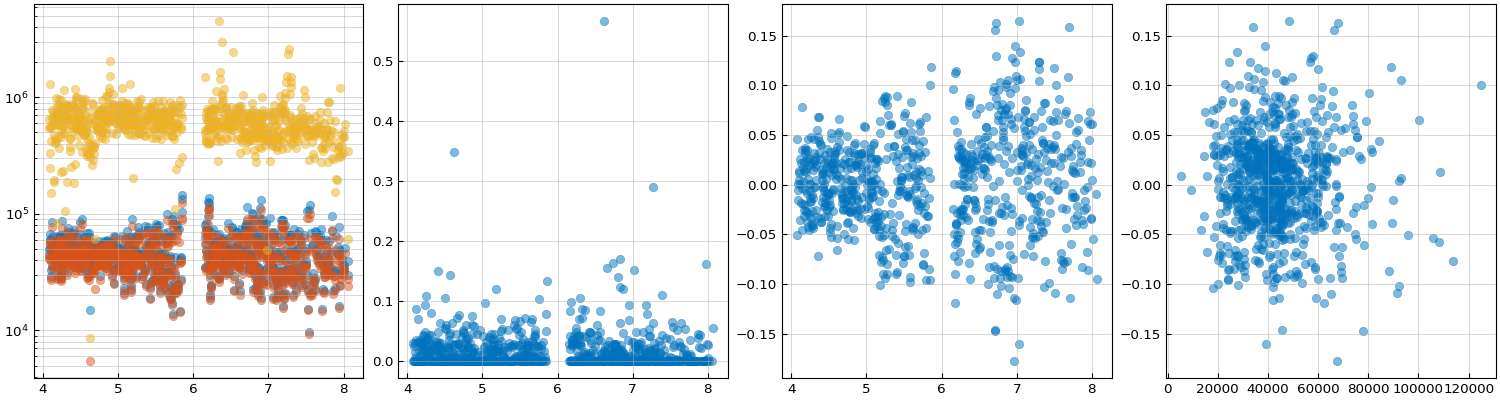

In [57]:
mode = 'trim'
meas = mode + 'measured'
design = mode + 'design'

fig, axes = plt.subplot_mosaic('abcd', figsize=(15, 4), constrained_layout=True)
fm = master[meas]['f0']
fd = master[design]['f0']
Qc = master[meas]['Qc']
Ql = master[meas]['Ql']
Qi = master[meas]['Qi']
a = master[meas]['a_nonlin']
dw = master[meas]['dw']
ax = axes['a']
ax.scatter(fm[~too_close_mask], Qc[~too_close_mask], alpha=0.5)
ax.scatter(fm[~too_close_mask], Ql[~too_close_mask], alpha=0.5)
ax.scatter(fm[~too_close_mask], Qi[~too_close_mask], alpha=0.5)
ax.set_yscale('log')
ax = axes['b']
ax.scatter(fm[~too_close_mask], a[~too_close_mask], alpha=0.5)
ax = axes['c']
phi = np.arctan(2*Ql*dw/(2*np.pi*fm))
ax.scatter(fm[~too_close_mask], phi[~too_close_mask], alpha=0.5)
ax = axes['d']
ax.scatter(Ql[~too_close_mask], phi[~too_close_mask], alpha=0.5)



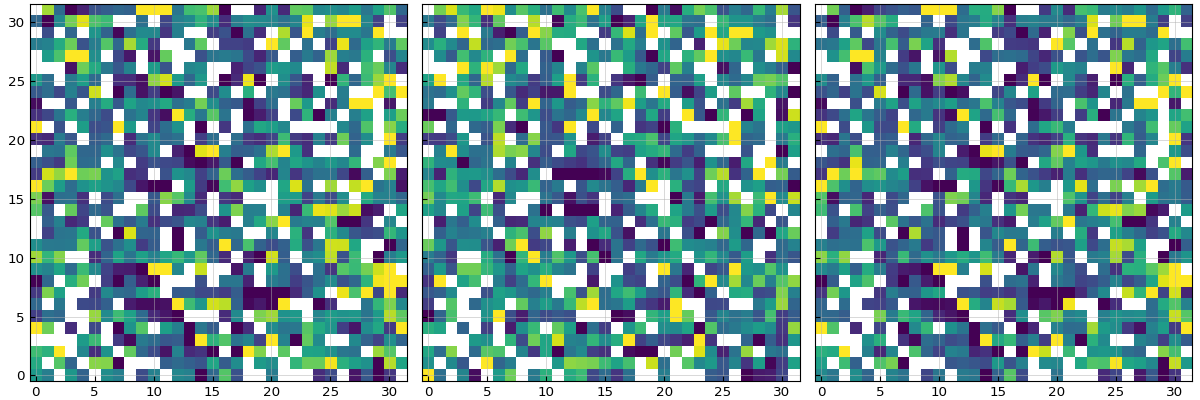

In [58]:
map = np.ones((32,32), dtype=int)
map[master['design']['row'].astype(int), master['design']['col'].astype(int)] = np.arange(1024)
fig, axes = plt.subplot_mosaic('abc', figsize=(12,4), sharey=True, constrained_layout=True) 
keys = ['Ql', 'Qi', 'Qc']
for i, ax in enumerate(axes):
    key = keys[i]
    Q = master[meas][key]
    Q[too_close_mask] = np.nan
    Q_map = Q[map]
    # Q_map = median_filter(Q_map, size=(1,3))
    axes[ax].imshow(Q_map, origin='lower', cmap='viridis', vmin=np.nanpercentile(Q, 5), vmax=np.nanpercentile(Q, 95))

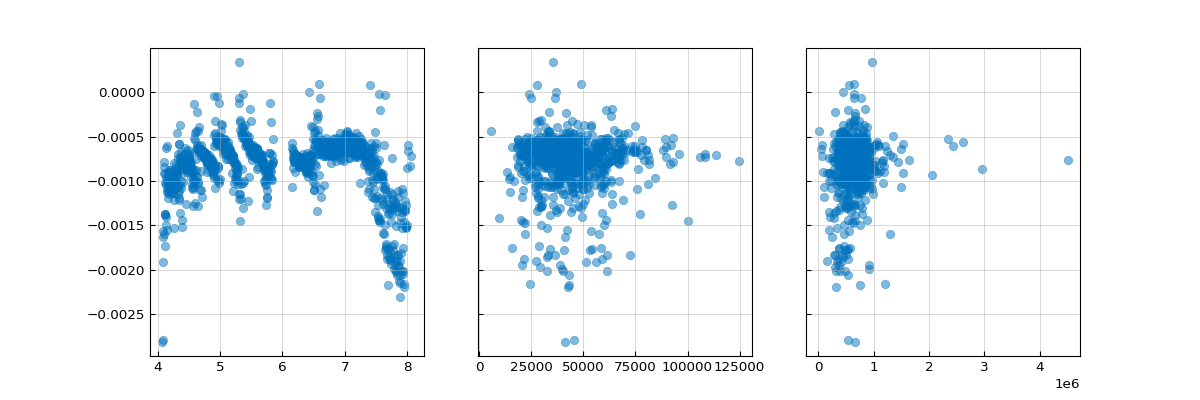

In [59]:
fig, axes = plt.subplot_mosaic('abc', figsize=(12,4), sharey=True)
ax = axes['a']
df_f = (fm - fd) / fd
ax.scatter(fm, df_f, alpha=0.5)
ax = axes['b']
ax.scatter(Ql[~too_close_mask], df_f[~too_close_mask], alpha=0.5)
ax = axes['c']
ax.scatter(Qi[~too_close_mask], df_f[~too_close_mask], alpha=0.5)

C:\Users\wilbertr\AppData\Local\Temp\ipykernel_33800\2024868101.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplot_mosaic('ab', figsize=(8,4), constrained_layout=True)


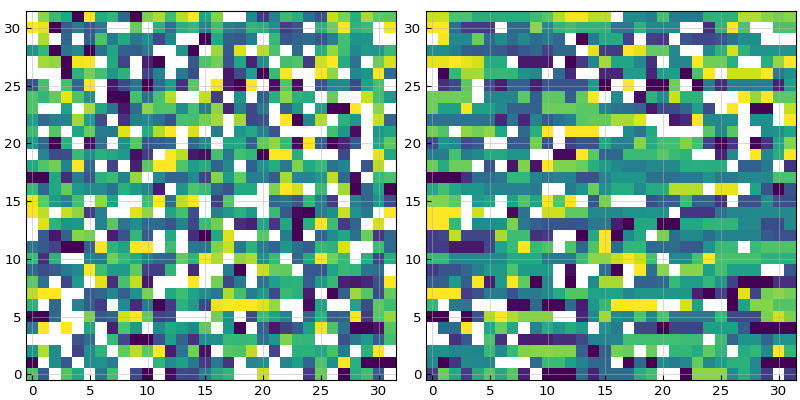

In [62]:
map = np.ones((32,32), dtype=int)
map[master['design']['row'].astype(int), master['design']['col'].astype(int)] = np.arange(1024)
fig, axes = plt.subplot_mosaic('ab', figsize=(8,4), constrained_layout=True)
ax = axes['a']
dw = master[meas]['dw']
Q =  master[meas]['Ql']
phi = np.arctan(2*Q*dw/master[label]['f0'])
phi[too_close_mask] = np.nan
dw_map = phi[map]
im = ax.imshow(dw_map, cmap='viridis', origin='lower', vmin=np.nanpercentile(dw_map, 5), vmax=np.nanpercentile(dw_map, 95))

phi[too_close_mask] = 0
dw_map = phi[map]
dw_filtered = median_filter(dw_map, size=(1, 5))
axes['b'].imshow(dw_filtered, cmap='viridis', origin='lower', vmin=np.nanpercentile(dw_filtered, 5), vmax=np.nanpercentile(dw_filtered, 95))